## Fraud Detection

Annual global fraud losses reached high limits, according to Nilson Report. About every 12 cents per $100 were stolen in the US during the 2018 year.

In this part of the series, we will train an Autoencoder Neural Network (implemented in Keras) in unsupervised (or semi-supervised) fashion for Anomaly Detection in credit card transaction data. The trained model will be evaluated on pre-labeled and anonymized dataset.

Import library 

In [263]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
import pydot
import wandb
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils.vis_utils import plot_model
from keras import regularizers
from wandb.keras import WandbCallback

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [264]:
# !wandb on
wandb.login() #53ee41127db8f2b5485f40cc7ba0d48d92538631
wandb.init(name='credit Fraud project with auto encoder', 
           project='credit-fraud',
           tags=['Kaggle-Data-Credit-Card-Fraud-Detection', 'Test Run'])


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


_runtime,1271
_timestamp,1621790298
_step,0


_runtime,▁
_timestamp,▁
_step,▁


## Load Dataset
The dataset we’re going to use can be downloaded from github. It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.
All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven’t been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [265]:
# df = pd.read_csv("https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv")
df = pd.read_csv('creditdata.csv').drop(['Unnamed: 0'], axis=1)
print(df.columns)
df.head(n=5)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Explore

31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. Let’s check for missing values:

In [266]:
# df.to_csv('creditdata.csv')

In [267]:
print('Check number of Rows and Columns')
print(df.shape)

print('Check if any Missing values')
df.isnull().values.any()

Check number of Rows and Columns
(284807, 31)
Check if any Missing values


False

Check distribution of 2 classes (Normal and Fraud)

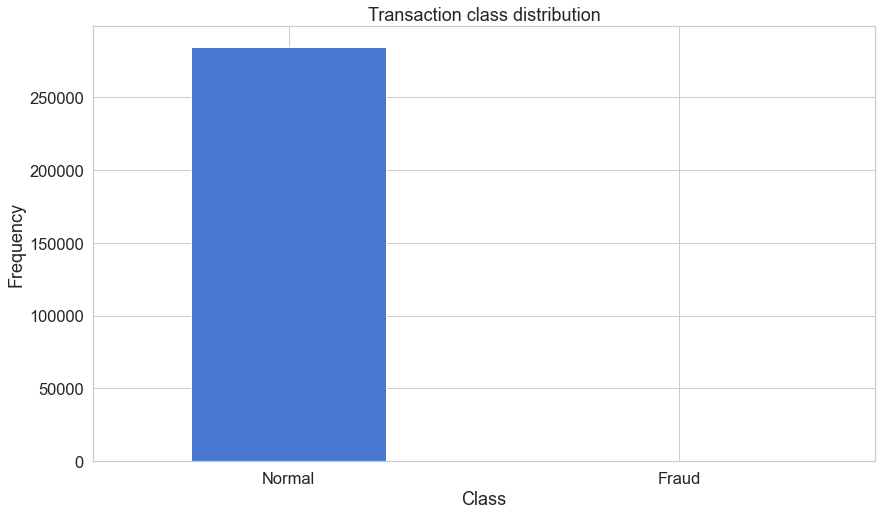

In [268]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let’s look at the two types of transactions:

In [269]:
print ('Number of Fraud Transctions')
frauds = df[df.Class == 1]
print(frauds.shape)

print ('Number of Normal Transctions')
normal = df[df.Class == 0]
print(normal.shape)

Number of Fraud Transctions
(492, 31)
Number of Normal Transctions
(284315, 31)


Let’s have a more graphical representation:

In [270]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

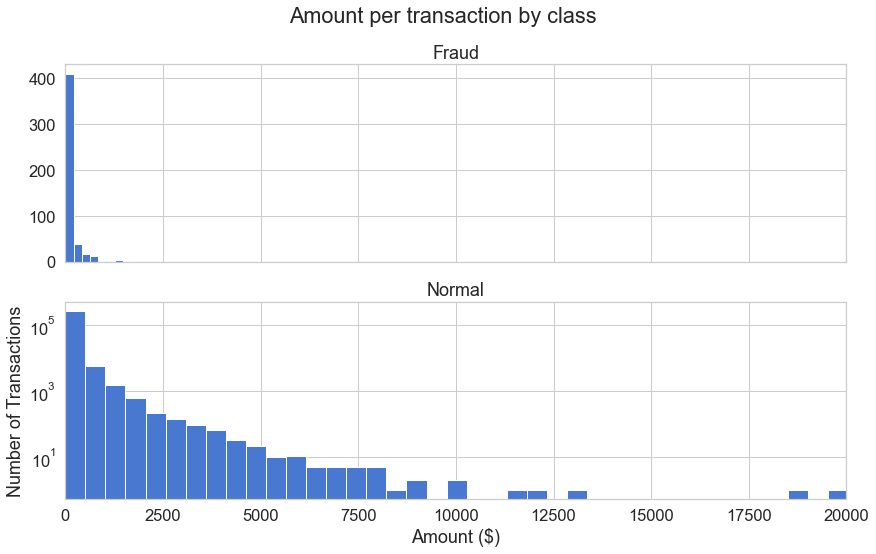

In [271]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = 10)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();


Do fraudulent transactions occur more often during certain time?


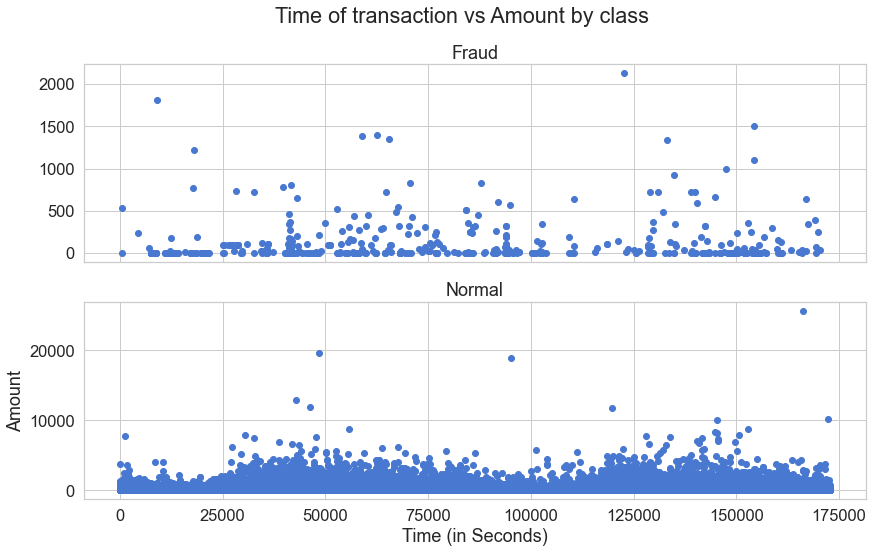

In [272]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

wandb.log({"hist": wandb.Image(f)}, commit=False)

Doesn’t seem like the time of transaction really matters.


## Autoencoders
Autoencoders can seem quite bizarre at first. The job of those models is to predict the input, given that same input. Puzzling?


More specifically, let’s take a look at Autoencoder Neural Networks. This Autoencoder tries to learn to approximate the following identity function:


![link text](https://miro.medium.com/max/312/1*aj1coSJRGTt7XwiqjCUGDA.png)



While trying to do just that might sound trivial at first, it is important to note that we want to learn a compressed representation of the data, thus find structure. This can be done by limiting the number of hidden units in the model. Those kind of autoencoders are called undercomplete.
Here’s a visual representation of what an Autoencoder might learn:

![link text](https://miro.medium.com/max/1050/1*HIBRgSV2ePFtCSOF_lgPCQ.png)

## Reconstruction error

We optimize the parameters of our Autoencoder model in such way that a special kind of error — reconstruction error is minimized. In practice, the traditional squared error is often used:

![link text](https://miro.medium.com/max/558/1*AW-qePBQ9sYxwFaSADDbgA.png)

## Preparing the data
First, let’s drop the Time column (not going to use it) and use the scikit’s StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [273]:
from sklearn.preprocessing import StandardScaler
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

Training our Autoencoder is gonna be a bit different from what we are used to. Let’s say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions. We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:

In [274]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(227451, 29)

## Building the model
Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively. The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [275]:
input_dim = X_train.shape[1]
encoding_dim = 14
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()


Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_20 (Dense)             (None, 14)                420       
_________________________________________________________________
dense_21 (Dense)             (None, 7)                 105       
_________________________________________________________________
dense_22 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_23 (Dense)             (None, 29)                232       
Total params: 813
Trainable params: 813
Non-trainable params: 0
_________________________________________________________________


Let’s train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally, the training progress will be exported in a format that TensorBoard understands.

In [ ]:
nb_epoch = 30
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
wandbcb = WandbCallback()
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard, wandbcb]).history

And load the saved model (just to check if it works):


In [ ]:
# !pip install pydot
# !pip install wandb

In [276]:
autoencoder = load_model('model.h5')

plot_model(autoencoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# wandb.watch(autoencoder)
autoencoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 14)                420       
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_7 (Dense)              (None, 29)                232       
Total params: 813
Trainable params: 813
Non-trainable params: 0
_________________________________________________________________


## Evaluation


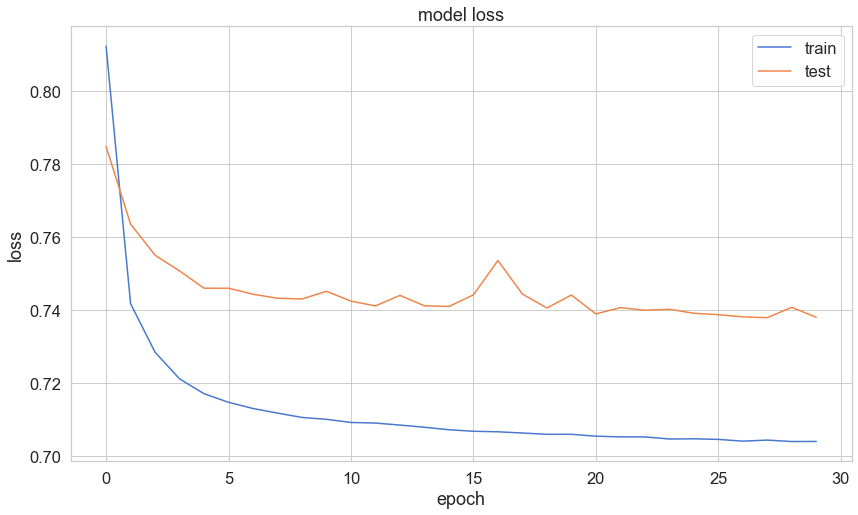

In [277]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
# fig = plt.figure()
# fig.save
# wandb.log({"loss2": wandb.Image(plt)}, commit=True)

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let’s have a closer look at the error distribution:

In [278]:
X_test.shape
X_test[:2]

array([[-16.52650657,   8.5849718 , -18.64985319,   9.50559351,
        -13.79381853,  -2.8324043 , -16.7016943 ,   7.5173439 ,
         -8.50705864, -14.11018444,   5.29923635, -10.83400648,
          1.67112025,  -9.37385858,   0.36080564,  -9.89924654,
        -19.23629237,  -8.398552  ,   3.10173537,  -1.51492344,
          1.1907387 ,  -1.12767001,  -2.35857877,   0.67346133,
         -1.41369967,  -0.46276236,  -2.01857525,  -1.04280417,
          1.10283362],
       [  0.33981206,  -2.74374524,  -0.13406951,  -1.38572931,
         -1.45141332,   1.01588659,  -0.52437906,   0.22406038,
          0.89974601,  -0.56501168,  -0.08767026,   0.97942699,
          0.07688282,  -0.21788381,  -0.13682959,  -2.14289209,
          0.12695607,   1.75266151,   0.43254622,   0.50604388,
         -0.21343584,  -0.94252503,  -0.52681917,  -1.1569919 ,
          0.31121051,  -0.74664668,   0.0409958 ,   0.10203782,
          1.7262552 ]])

56864 56864


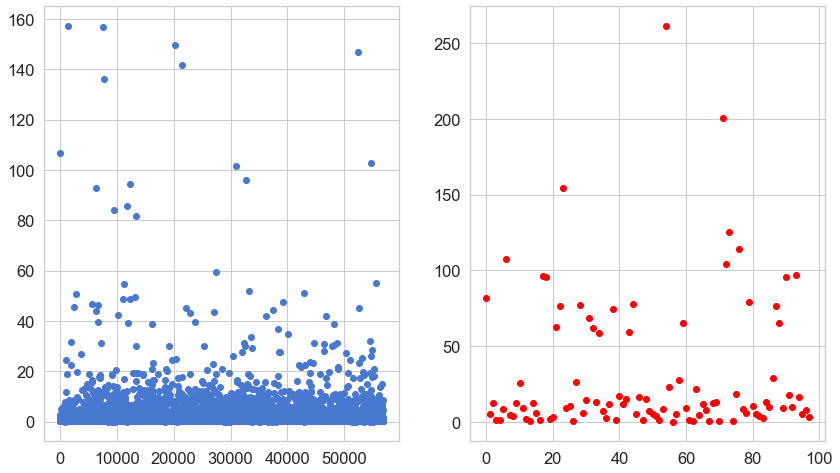

(261.3492313738173,
 56962,
 ModeResult(mode=array([0.27219052]), count=array([17])),
         reconstruction_error  true_class
 43428              81.869677           1
 49906               0.736210           0
 29474               0.197499           0
 276481              0.437764           0
 278846              0.172842           0,
        reconstruction_error    true_class
 count          56962.000000  56962.000000
 mean               0.737045      0.001720
 std                3.407418      0.041443
 min                0.045951      0.000000
 25%                0.239904      0.000000
 50%                0.393231      0.000000
 75%                0.632208      0.000000
 max              261.349231      1.000000)

In [279]:
from scipy import stats

predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
fig , (ax1,ax2) = plt.subplots(1,2)
err_normal = error_df[error_df['true_class'] == 0]['reconstruction_error'].values
err_fraud = error_df[error_df['true_class'] == 1]['reconstruction_error'].values
print(err_normal.shape[0] , len(err_normal))
ax1.scatter( range(len(err_normal)), err_normal)
ax2.scatter( range(len(err_fraud)), err_fraud, c='red')

# plt.scatter(err_fraud, range(err_fraud.shape[0]), 'r')#mse, range(len(mse)))
# plt.scatter(error_df['true_class'] , error_df['reconstruction_error'] )
plt.show()

ax.hist([m for m in mse if m>10] , bins = 10)
# wandb.log({"hist": wandb.Image(fig)}, commit=False)
# wandb.log({"mse": mse})

max(mse), len(mse), stats.mode(mse), error_df.head(), error_df.describe()

## Reconstruction error without fraud


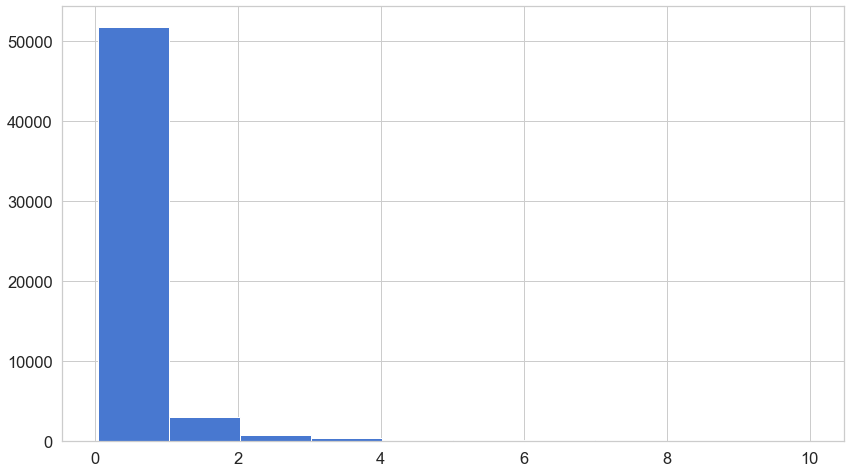

In [280]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
# plt.scatter(error_df['true_class'] , error_df['reconstruction_error'])
# plt.show()
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)
wandb.log({"hist": wandb.Image(fig)}, commit=False)

plt.show()

## Reconstruction error with fraud


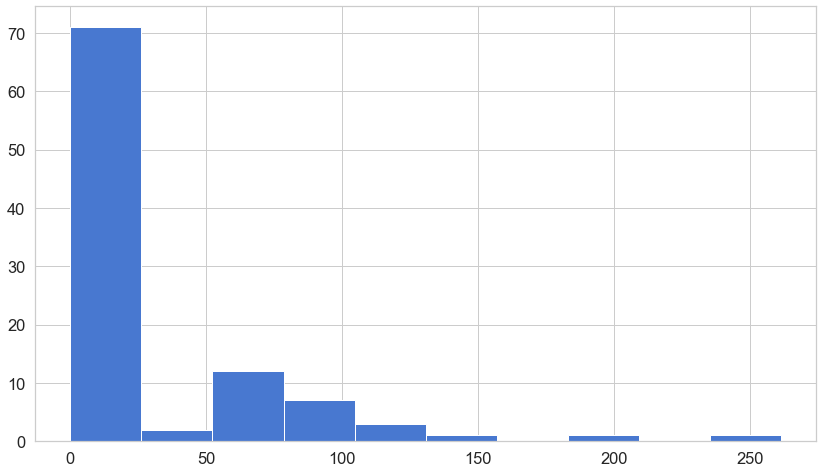

In [281]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [282]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_auc_score ,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let’s have a look at our ROC curve:

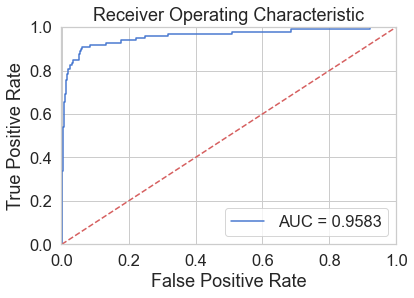

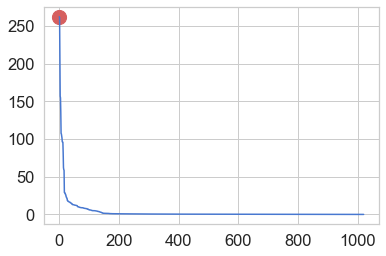

In [285]:
# %matplotlib inline
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)
fig, ax= plt.subplots()
# ax = fig.add_subplot(111)

ax.set_title( 'Receiver Operating Characteristic')
ax.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
ax.legend(loc='lower right')
ax.plot([0,1],[0,1],'r--')

ax.set_xlim([-0.001, 1])
ax.set_ylim([0, 1.001])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')

wandb.log({"ROC": wandb.Image(fig)}, commit=True)

plt.show();
len(thresholds), min(thresholds), max(thresholds)
fig, ax= plt.subplots()
optimal_idx = np.argmin(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
ax.plot(thresholds, label='Optimal = %0.4f'% optimal_threshold)
# print(roc_auc_score(error_df.true_class, error_df.reconstruction_error))
ax.scatter(optimal_idx, optimal_threshold, s = 200, c = 'r')
wandb.log({"Optimal Threshold": wandb.Image(fig)}, commit=True)
wandb.log({"Thresholds": thresholds ,"Optimal Threshold": optimal_threshold } )
plt.show();

The ROC curve plots the true positive rate versus the false positive rate, over different threshold values. Basically, we want the blue line to be as close as possible to the upper left corner. While our results look pretty good, we have to keep in mind of the nature of our dataset. ROC doesn’t look very useful for us. Onward…

## Precision vs Recall

![link text](https://miro.medium.com/max/525/1*kaqtNALKZujx1FGlbK11OQ.png)

Precision and recall are defined as follows:

![link text](https://miro.medium.com/max/1050/1*R7ctLbxIZ0u9TYi2gHD-5g.png)

![link text](https://miro.medium.com/max/1050/1*xhbEGpdppXOgPHN0VPjVjw.png)

Let’s take an example from Information Retrieval in order to better understand what precision and recall are. Precision measures the relevancy of obtained results. Recall, on the other hand, measures how many relevant results are returned. Both values can take values between 0 and 1. You would love to have a system with both values being equal to 1.


Let’s return to our example from Information Retrieval. High recall but low precision means many results, most of which has low or no relevancy. When precision is high but recall is low we have the opposite — few returned results with very high relevancy. Ideally, you would want high precision and high recall — many results with that are highly relevant.


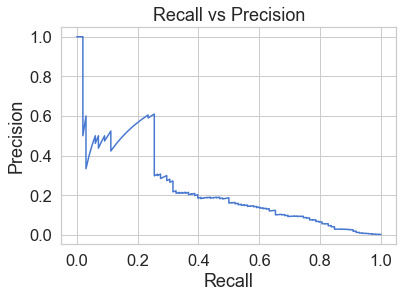

In [286]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
fig, ax= plt.subplots()
ax.plot(recall, precision, 'b', label='Precision-Recall curve')
ax.set_title('Recall vs Precision')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

wandb.log({"Recall vs Precision": wandb.Image(fig)}, commit=True)
plt.show()

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

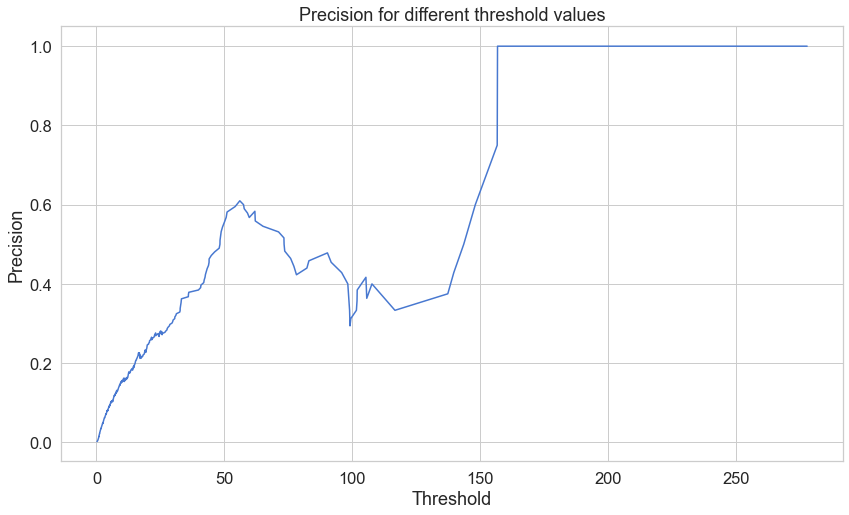

In [56]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

You can see that as the reconstruction error increases our precision rises as well. Let’s have a look at the recall:

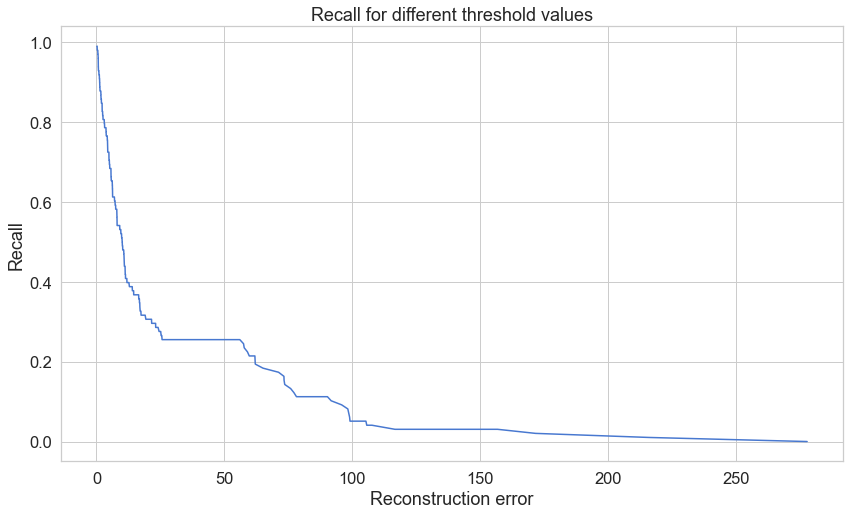

In [57]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases.

## Prediction
Our model is a bit different this time. It doesn’t know how to predict new values. But we don’t need that. In order to predict whether or not a new/unseen transaction is normal or fraudulent, we’ll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we’ll mark it as a fraud (since our model should have a low error on normal transactions). Let’s pick that value:

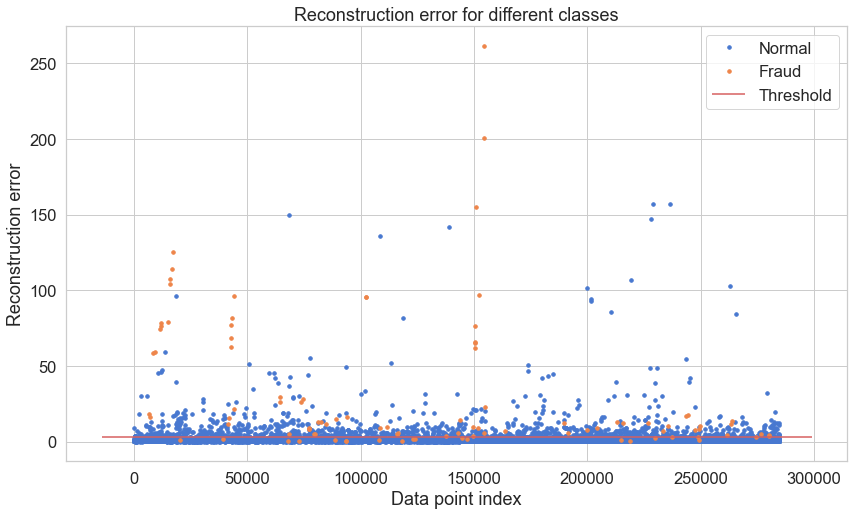

In [123]:
threshold = 3 #optimal_threshold

## And see how well we’re dividing the two types of transactions:

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")

wandb.log({"Reconstruction error for different classes": wandb.Image(fig)}, commit=True)

plt.show();

I know, that chart might be a bit deceiving. Let’s have a look at the confusion matrix:

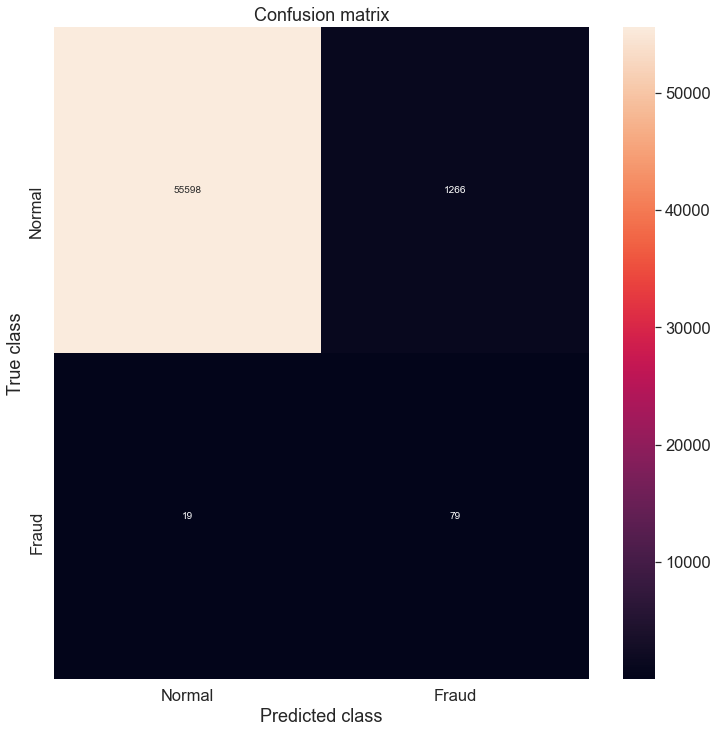

In [287]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
fig = plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
wandb.log({"Confusion matrix at threshold" + str(threshold) : wandb.Image(fig)}, commit=True)
plt.show()

Our model seems to catch a lot of the fraudulent cases. Of course, there is a catch (see what I did there?). The number of normal transactions classified as frauds is really high. Is this really a problem? Probably it is. You might want to increase or decrease the value of the threshold, depending on the problem. That one is up to you.


## Conclusion
We’ve created a very simple Deep Autoencoder in Keras that can reconstruct what non fraudulent transactions looks like. Initially, I was a bit skeptical about whether or not this whole thing is gonna work out, bit it kinda did. Think about it, we gave a lot of one-class examples (normal transactions) to a model and it learned (somewhat) how to discriminate whether or not new examples belong to that same class. Isn’t that cool? Our dataset was kind of magical, though. We really don’t know what the original features look like.

Keras gave us very clean and easy to use API to build a non-trivial Deep Autoencoder. You can search for TensorFlow implementations and see for yourself how much boilerplate you need in order to train one. Can you apply a similar model to a different problem?



In [288]:
threshold_range = range(1,101)
fpr_list , tpr_list, conf_list = [] , [], []
for threshold in threshold_range :
    #threshold = 50 #2.9
    groups = error_df.groupby('true_class')

    y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
    conf_matrix = confusion_matrix(error_df.true_class, y_pred)
    conf_list.append(conf_matrix)
    fpr, tpr, thresholds = roc_curve(error_df.true_class, y_pred)
    fpr_list.append(fpr[1])
    tpr_list.append(tpr[1])
    
# plt.plot(fpr_list)

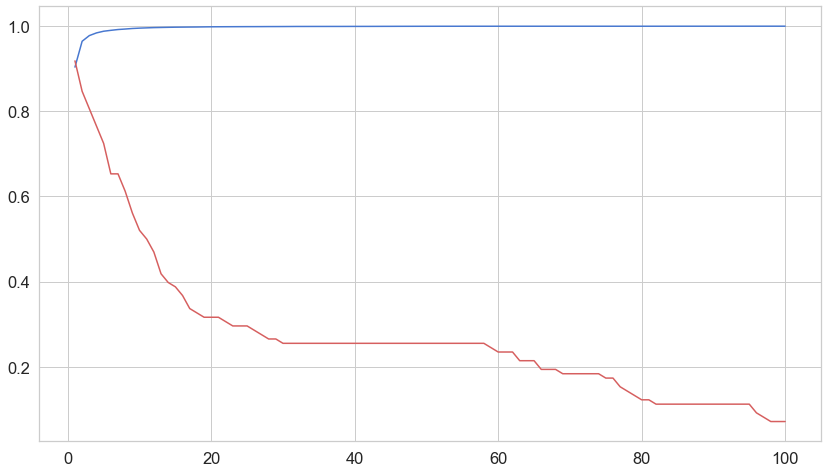

In [61]:
fig, ax = plt.subplots()
ax.plot(threshold_range, fpr_list, 'b')
ax.plot(threshold_range, tpr_list, 'r')
wandb.log({" fpr, tpr @ threshold range "  : wandb.Image(fig)}, commit=True)

# plt.point(max(fpr_list))

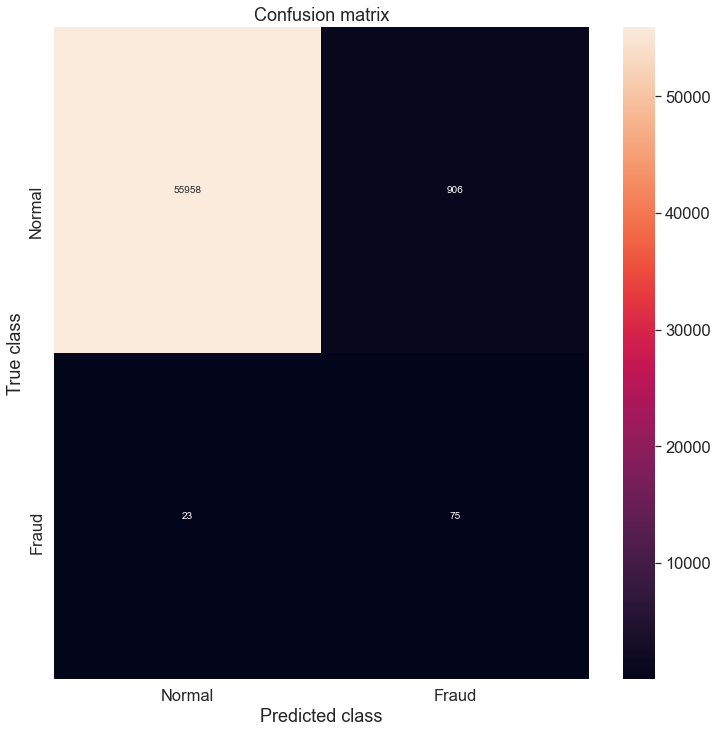

In [305]:
t = 4
y_pred = [1 if e > t else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
# fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
# roc_auc = auc(fpr, tpr)
# fig, ax= plt.subplots()
# # ax = fig.add_subplot(111)

# ax.set_title( 'Receiver Operating Characteristic')
# ax.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
# ax.legend(loc='lower right')
# ax.plot([0,1],[0,1],'r--')
# ax.set_xlim([-0.001, 1])
# ax.set_ylim([0, 1.001])
# ax.set_ylabel('True Positive Rate')
# ax.set_xlabel('False Positive Rate')

# wandb.log({"ROC": wandb.Image(fig)}, commit=True)

# plt.show();
# thresholds

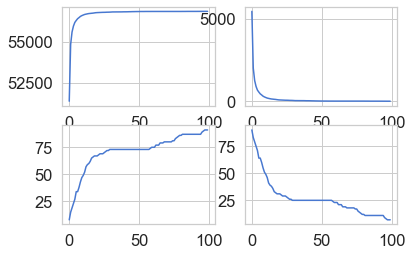

In [306]:
fig, ax = plt.subplots(2,2)
# ax.plot(conf_list[:,0])
# print(conf_list[:3], np.array(conf_list).shape)
conf_arr = np.array(conf_list)
conf_arr_flat = conf_arr.reshape(np.array(conf_list).shape[0]*np.array(conf_list).shape[1]*np.array(conf_list).shape[2],1)
conf_arr_flat[::4][:3],conf_arr_flat[1::4][:3],conf_arr_flat[2::4][:3],conf_arr_flat[3::4][:3]
#ax[0][0].vlines(threshold, ax[0][0].get_xlim()[0], ax[0][0].get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax[0][0].plot(conf_arr_flat[::4], label='TP')
ax[0][1].plot(conf_arr_flat[1::4])
ax[1][0].plot(conf_arr_flat[2::4])
ax[1][1].plot(conf_arr_flat[3::4])
plt.show()

[array([[51391,  5473],
       [    8,    90]], dtype=int64), array([[54842,  2022],
       [   15,    83]], dtype=int64), array([[55598,  1266],
       [   19,    79]], dtype=int64)] (100, 2, 2)


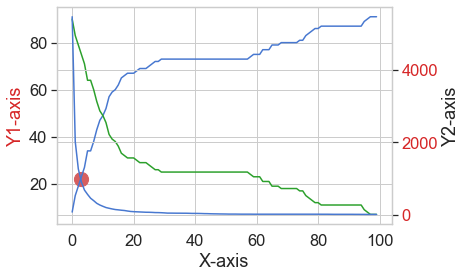

In [299]:
fig, ax = plt.subplots()
# ax.plot(conf_list[:,0])
print(conf_list[:3], np.array(conf_list).shape)
conf_arr = np.array(conf_list)
conf_arr_flat = conf_arr.reshape(np.array(conf_list).shape[0]*np.array(conf_list).shape[1]*np.array(conf_list).shape[2],1)
conf_arr_flat[::4][:3],conf_arr_flat[1::4][:3],conf_arr_flat[2::4][:3],conf_arr_flat[3::4][:3]
#ax.vlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

color = 'tab:red'
ax.set_xlabel('X-axis') 
ax.set_ylabel('Y1-axis', color = color) 
# ax.plot(conf_arr_flat[1::4])
ax.plot(conf_arr_flat[2::4])
ax.plot(conf_arr_flat[3::4], color = 'tab:green')
ax.scatter(2.9, 22, s = 200, c = 'r')
ax2 = ax.twinx()

ax2.set_ylabel(r"Y2-axis")
# ax2.plot(conf_arr_flat[::4], label='TP')
ax2.plot(conf_arr_flat[1::4])
ax2.tick_params(axis ='y', labelcolor = color) 


plt.show()


# this is how we came to conclusion that 2.9 is a optimal threshold value

In [303]:
conf_arr[:10]

array([[[51391,  5473],
        [    8,    90]],

       [[54842,  2022],
        [   15,    83]],

       [[55598,  1266],
        [   19,    79]],

       [[55958,   906],
        [   23,    75]],

       [[56182,   682],
        [   27,    71]],

       [[56301,   563],
        [   34,    64]],

       [[56408,   456],
        [   34,    64]],

       [[56475,   389],
        [   38,    60]],

       [[56548,   316],
        [   43,    55]],

       [[56595,   269],
        [   47,    51]]], dtype=int64)